# CIFAR10 데이터로 신경한 훈련

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [ ]:
print(train_images.shape, train_labels.shape) #airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck 순으로 10개의 라벨
print(test_images.shape, test_labels.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
train_labels[:10]

array([[6],
       [9],
       [9],
       [4],
       [1],
       [1],
       [2],
       [7],
       [8],
       [3]], dtype=uint8)

### 데이터 시각화

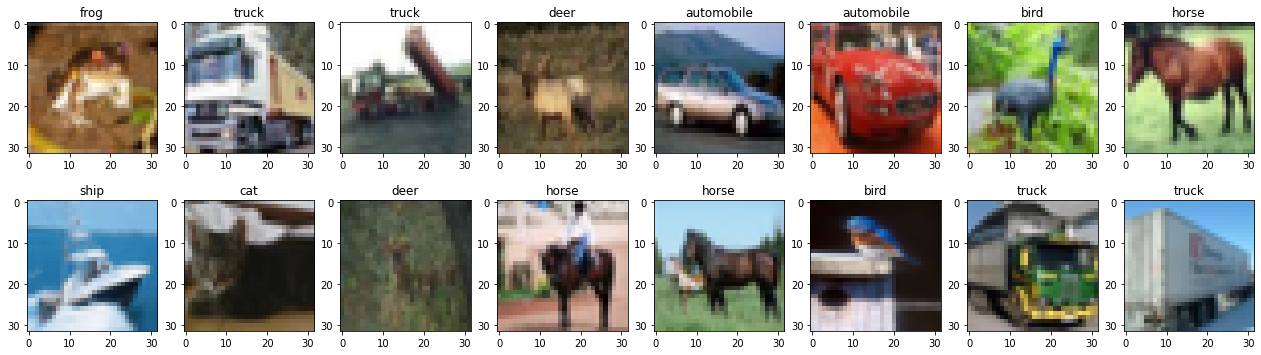

In [ ]:
plt.figure(figsize = (22,6))

for i in range(16):
    ax = plt.subplot(2, 8, i+1)
    ax.set_title(class_names[train_labels.flatten()[i]])
    ax.imshow(train_images[i])

### 데이터 전처리

In [ ]:
train_images = np.array(train_images/255.0, dtype=np.float32)
train_labels = np.array(train_labels, dtype=np.float32)
test_images = np.array(test_images/255.0, dtype=np.float32)
test_labels = np.array(test_labels, dtype=np.float32)

train_oh_labels = to_categorical(train_labels)
test_oh_labels = to_categorical(test_labels)

from sklearn.model_selection import train_test_split
train_images, valid_images, train_oh_labels, valid_oh_labels = train_test_split(train_images, train_oh_labels, test_size=0.2, random_state=42)

#### 데이터 증강

데이터 증강은 원본의 개수가 유지되는데 다양한 특성으로 데이터를 가공하는 것임

원래라면 전처리(스케일링, lable_encoding) 학습(fit)(batchsize가공 등등)의 형태지만

증강을 통해서 데이터 전처리, generator(generate(aug, 스케일링), flow[batchsize, lable_encoder)) 등을 정의한 것을 iterator형태로 전해주면 batchsize만큼 가져와서 fit을 한다.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator #yield를 이용해서 잠깐 return하고 돌아오는 함수가 generator

In [ ]:
train_images[0].shape

(32, 32, 3)

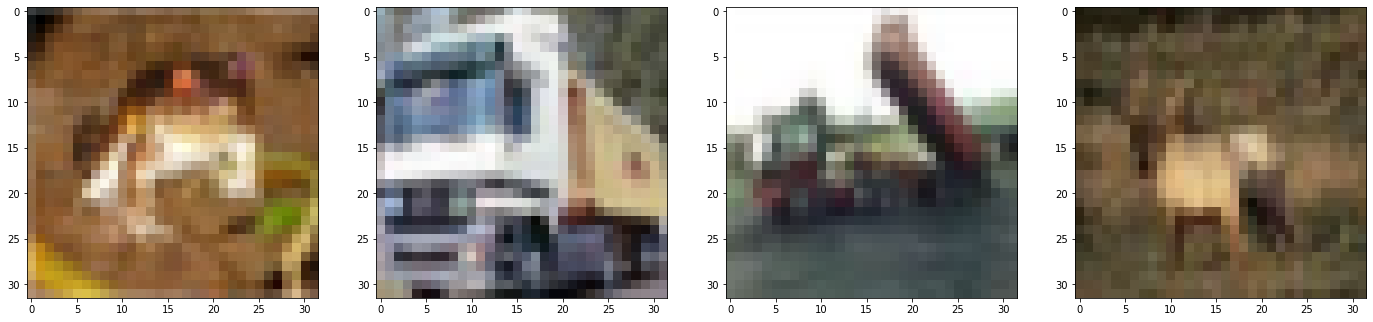

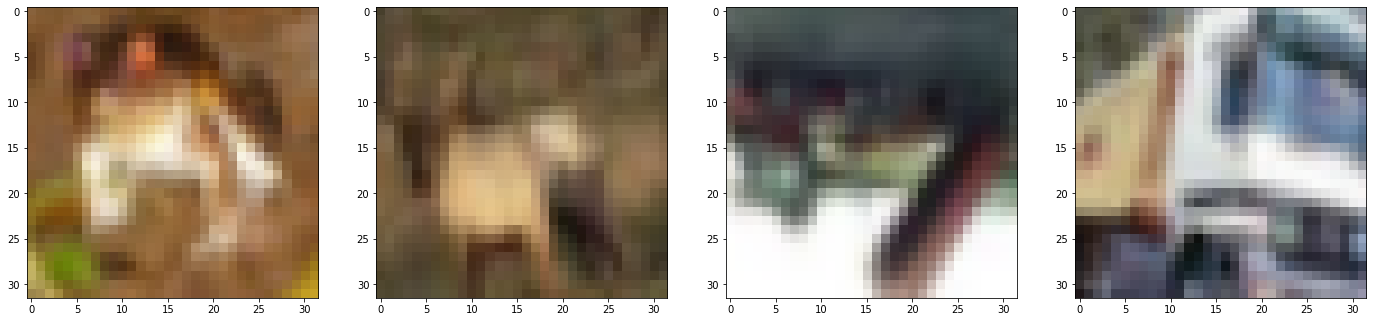

In [ ]:
#data_generator = ImageDataGenerator(horizontal_flip = True) #옵션(파라미터)설정
#data_generator = ImageDataGenerator(rotation_range = 30)
#data_generator = ImageDataGenerator(zoom_range=(0.7, 0.9))
#data_generator = ImageDataGenerator(vertical_flip= True)
data_generator = ImageDataGenerator(horizontal_flip = True,
                                    rotation_range = 30,
                                    vertical_flip= True,
                                    zoom_range=(0.7, 0.9)
                                    )


images = train_images[:4]

#image = np.expand_dims(train_images[0], axis=0) #열 방향으로 1칸 늘어난다.
data_generator_iterator = data_generator.flow(images) #iterator로 변경

augmented_images = next(data_generator_iterator) #증강시킨다.
#print(augmented_image.shape)

#augmented_image = np.squeeze(augmented_image) #차원 축소
#print(augmented_image.shape)

#image = np.squeeze(image)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(6*4, 8))
for i, image in enumerate(images):
  axes[i].imshow(image)

fig2, axes = plt.subplots(nrows=1, ncols=4, figsize=(6*4, 8))
for i, aug_image in enumerate(augmented_images):
  axes[i].imshow(aug_image)

In [ ]:
train_images.shape

(40000, 32, 32, 3)

In [ ]:
BATCH_SIZE = 64
train_generator = ImageDataGenerator(horizontal_flip = True)
train_generator_iterator = train_generator.flow(train_images, train_oh_labels, batch_size=BATCH_SIZE)
valid_generator = ImageDataGenerator()
valid_generator_iterator = train_generator.flow(valid_images, valid_oh_labels, batch_size=BATCH_SIZE)

### 모델 생성

In [ ]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, MaxPooling3D, BatchNormalization, Activation

In [135]:
def build_model():
    tf.keras.backend.clear_session() #기존에 있던 모델 클리어

    input_tensor = Input(shape = (32, 32, 3))
    x = Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same')(x) # valid는 패딩 False와 같음
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)   ## 이런 모양새 하나를 블럭이라고 한다.


    x = Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same')(x) # valid는 패딩 False와 같음
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)


    x = Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding='same')(x) # valid는 패딩 False와 같음
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)


  #x = Conv2D(filters=256, kernel_size=(2, 2), strides=1, padding='same', activation='relu')(x)
  #x = Conv2D(filters=256, kernel_size=(2, 2), strides=1, padding='same', activation='relu')(x) # valid는 패딩 False와 같음
  #x = MaxPooling2D(pool_size=(2,2))(x)

    print(x.shape)
    x = Flatten()(x)
    print(x.shape)
    x = Dropout(0.5)(x)
    x = Dense(300, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(10, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=output)
  
    return model

In [136]:
model = build_model()

(None, 4, 4, 128)
(None, 2048)


## 모델 컴파일

In [137]:
model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy']) #원-핫 인코딩을 안쓰면 categorical을 굳이 안써도 된다. binary_cateogorical

In [138]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [139]:
checkpoint_cb = ModelCheckpoint("my_keras_model.h5", save_best_only=True, verbose=1) 
early_stopping_cb = EarlyStopping(patience=15, restore_best_weights=True)
reducelr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)

In [140]:
history = model.fit(train_generator_iterator, validation_data=valid_generator_iterator,
                    epochs=40, callbacks=[checkpoint_cb, reducelr_cb, early_stopping_cb]) 

Epoch 1/40
625/625 [==============================] - 16s 24ms/step - loss: 1.6514 - accuracy: 0.3826 - val_loss: 1.3192 - val_accuracy: 0.5228

Epoch 00001: val_loss improved from inf to 1.31917, saving model to my_keras_model.h5
Epoch 2/40
625/625 [==============================] - 15s 23ms/step - loss: 1.2509 - accuracy: 0.5522 - val_loss: 1.0314 - val_accuracy: 0.6264

Epoch 00002: val_loss improved from 1.31917 to 1.03135, saving model to my_keras_model.h5
Epoch 3/40
625/625 [==============================] - 15s 23ms/step - loss: 1.0555 - accuracy: 0.6311 - val_loss: 0.9229 - val_accuracy: 0.6720

Epoch 00003: val_loss improved from 1.03135 to 0.92286, saving model to my_keras_model.h5
Epoch 4/40
625/625 [==============================] - 15s 23ms/step - loss: 0.9349 - accuracy: 0.6762 - val_loss: 0.9294 - val_accuracy: 0.6845

Epoch 00004: val_loss did not improve from 0.92286
Epoch 5/40
625/625 [==============================] - 15s 23ms/step - loss: 0.8526 - accuracy: 0.7060 -

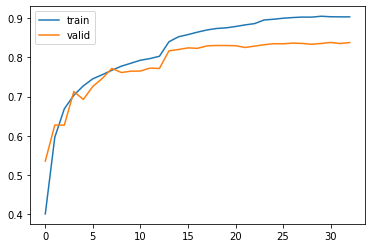

In [ ]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'valid')
plt.legend()

## 테이스 데이터에서 검증

In [ ]:
predict_proba = model.predict(np.reshape(test_images[0], (-1, 32, 32, 3)))
predict = np.argmax(predict_proba, axis=1)
predict

array([3])

In [ ]:
np.argmax(test_oh_labels, axis=1)

array([3, 8, 8, ..., 5, 1, 7])

In [134]:
model.evaluate(test_images, test_oh_labels, batch_size=64, verbose=1)

157/157 [==============================] - 2s 11ms/step - loss: 0.5359 - accuracy: 0.8332


[0.5358559489250183, 0.8331999778747559]

## 필터수, 은닉층 수 증가

#### 모델 생성

In [ ]:
def build_extended_model():
  tf.keras.backend.clear_session() #기존에 있던 모델 클리어

  input_tensor = Input(shape = (32, 32, 3))
  x = Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same')(input_tensor)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same')(x) # valid는 패딩 False와 같음
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = MaxPooling2D(pool_size=(2,2))(x)   ## 이런 모양새 하나를 블럭이라고 한다.


  x = Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding='same')(x) # valid는 패딩 False와 같음
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = MaxPooling2D(pool_size=(2,2))(x)


  x = Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same')(x) # valid는 패딩 False와 같음
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = MaxPooling2D(pool_size=(2,2))(x)

  x = Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same')(x) # valid는 패딩 False와 같음
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = MaxPooling2D(pool_size=(2,2))(x)


  #x = Conv2D(filters=256, kernel_size=(2, 2), strides=1, padding='same', activation='relu')(x)
  #x = Conv2D(filters=256, kernel_size=(2, 2), strides=1, padding='same', activation='relu')(x) # valid는 패딩 False와 같음
  #x = MaxPooling2D(pool_size=(2,2))(x)

  print(x.shape)
  x = Flatten()(x)
  print(x.shape)
  x = Dropout(0.5)(x)
  x = Dense(300, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(100, activation='relu')(x)
  x = Dropout(0.3)(x)
  output = Dense(10, activation='softmax')(x)

  model = Model(inputs=input_tensor, outputs=output)
  
  return model

### 모델 생성 및 컴파일

In [ ]:
model = build_extended_model()

(None, 2, 2, 512)
(None, 2048)


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0     

In [ ]:
model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy']) 

#### callback정의

In [ ]:
checkpoint_cb = ModelCheckpoint("my_keras_model.h5", save_best_only=True, verbose=1) 
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)
reducelr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)

### 모델 학습

In [ ]:
history = model.fit(x=train_images, y=train_oh_labels, validation_data=(test_images, test_oh_labels), epochs=40, batch_size=32, callbacks=[checkpoint_cb, reducelr_cb]) 

Epoch 1/40
1563/1563 [==============================] - 50s 31ms/step - loss: 1.6673 - accuracy: 0.3826 - val_loss: 1.5569 - val_accuracy: 0.4247

Epoch 00001: val_loss improved from inf to 1.55687, saving model to my_keras_model.h5
Epoch 2/40
1563/1563 [==============================] - 47s 30ms/step - loss: 1.1372 - accuracy: 0.6077 - val_loss: 1.1376 - val_accuracy: 0.6145

Epoch 00002: val_loss improved from 1.55687 to 1.13758, saving model to my_keras_model.h5
Epoch 3/40
1563/1563 [==============================] - 47s 30ms/step - loss: 0.9091 - accuracy: 0.6951 - val_loss: 0.9000 - val_accuracy: 0.6973

Epoch 00003: val_loss improved from 1.13758 to 0.89999, saving model to my_keras_model.h5
Epoch 4/40
1563/1563 [==============================] - 47s 30ms/step - loss: 0.7609 - accuracy: 0.7479 - val_loss: 0.7147 - val_accuracy: 0.7615

Epoch 00004: val_loss improved from 0.89999 to 0.71466, saving model to my_keras_model.h5
Epoch 5/40
1563/1563 [==============================] - 

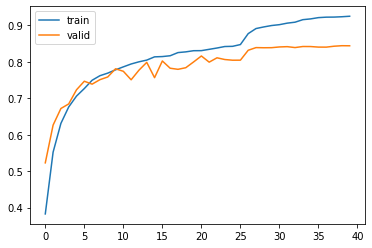

In [141]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'valid')
plt.legend()

### 테스트 에서 평가

In [142]:
model.evaluate(test_images, test_oh_labels, batch_size=64, verbose=1)

157/157 [==============================] - 2s 9ms/step - loss: 0.5885 - accuracy: 0.8409


[0.5885376334190369, 0.8409000039100647]

오버 피팅요소는 dropout, global avarge pooling, data_augementation으로 억제할 수 있다.